# PCA for Algorithmic Trading: Eigen Portfolios

## Imports & Settings

In [1]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA, FastICA
from sklearn.preprocessing import scale

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
np.random.seed(42)

## Eigenportfolios

Another application of PCA involves the covariance matrix of the normalized returns. The principal components of the correlation matrix capture most of the covariation among assets in descending order and are mutually uncorrelated. Moreover, we can use standardized the principal components as portfolio weights.

Let’s use the 30 largest stocks with data for the 2010-2018 period to facilitate the exposition:

### Data Preparation

In [3]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(30)
    returns = (store['quandl/wiki/prices']
               .loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker')
               .pct_change())

We again winsorize and also normalize the returns:

In [4]:
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=.025), 
                             upper=returns.quantile(q=.975), 
                             axis=1)
                      .apply(lambda x: x.sub(x.mean()).div(x.std())))

In [5]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2010-01-05 to 2018-03-27
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2070 non-null   float64
 1   AMZN    2070 non-null   float64
 2   BA      2070 non-null   float64
 3   BAC     2070 non-null   float64
 4   CSCO    2070 non-null   float64
 5   CVX     2070 non-null   float64
 6   GOOGL   2070 non-null   float64
 7   HD      2070 non-null   float64
 8   INTC    2070 non-null   float64
 9   JNJ     2070 non-null   float64
 10  JPM     2070 non-null   float64
 11  KO      2070 non-null   float64
 12  MA      2070 non-null   float64
 13  MSFT    2070 non-null   float64
 14  PFE     2070 non-null   float64
 15  PG      2070 non-null   float64
 16  T       2070 non-null   float64
 17  UNH     2070 non-null   float64
 18  V       2070 non-null   float64
 19  VZ      2070 non-null   float64
 20  WFC     2070 non-null   float64
 21  WMT     2070 non-nu

In [6]:
cov = returns.cov()

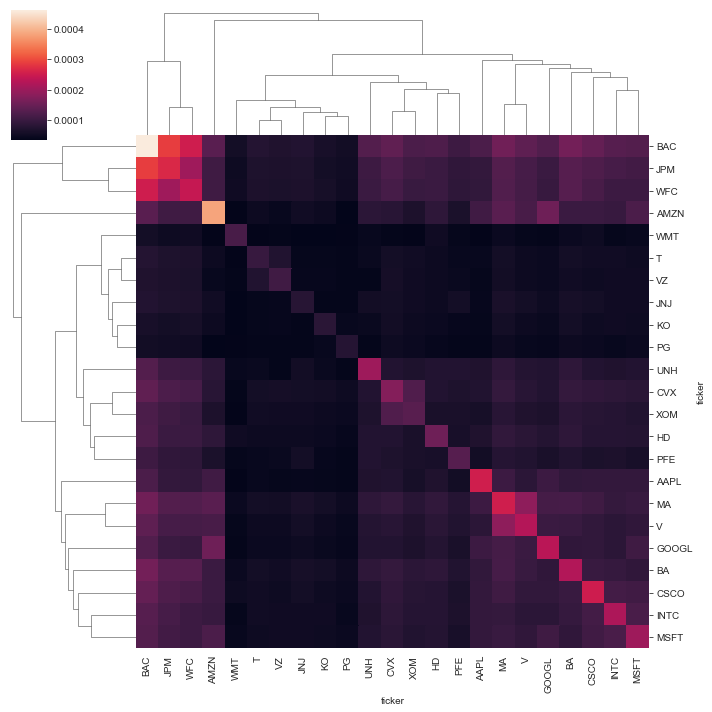

In [7]:
sns.clustermap(cov);

### Run PCA

After dropping assets and trading days as in the previous example, we are left with 23 assets and over 2,000 trading days. We estimate all principal components and find that the two largest explain 57.6% and 12.4% of the covariation, respectively:

In [8]:
pca = PCA()
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,55.90%
1,15.52%
2,5.36%
3,4.85%
4,3.32%


### Create PF weights from principal components

Next, we select and normalize the four largest components so that they sum to 1 and we can use them as weights for portfolios that we can compare to an equal-weighted portfolio formed from all stocks::

In [9]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

### Eigenportfolio Weights

The weights show distinct emphasis, e.g., portfolio 3 puts large weights on Mastercard and Visa, the two payment processors in the sampel whereas potfolio 2 has more exposure to some technology companies:

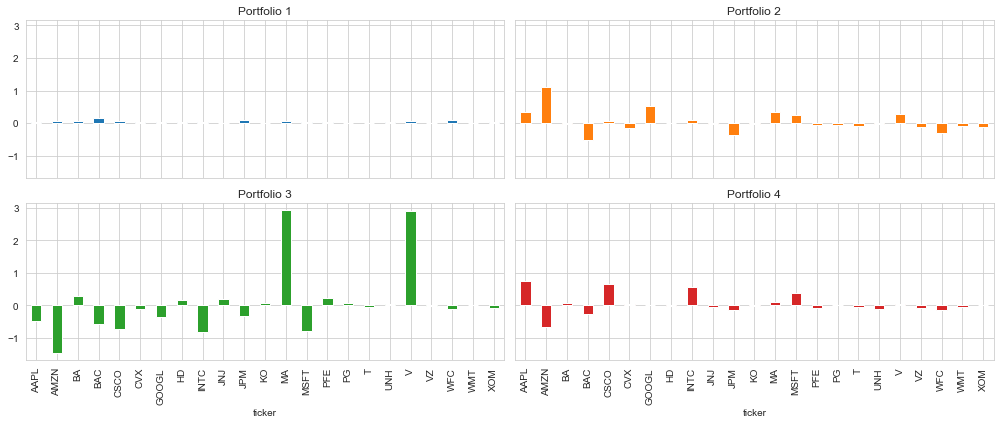

In [11]:
eigen_portfolios.T.plot.bar(subplots=True, layout=(2,2), figsize=(14,6), legend=False, sharey=True)
plt.tight_layout()
plt.savefig('../figures/pca_eigen_pf_weights', dpi=300);

### Eigenportfolio Performance

When comparing the performance of each portfolio over the sample period to ‘the market’ consisting of our small sample, we find that portfolio 1 performs very similarly, whereas the other portfolios capture different return patterns.

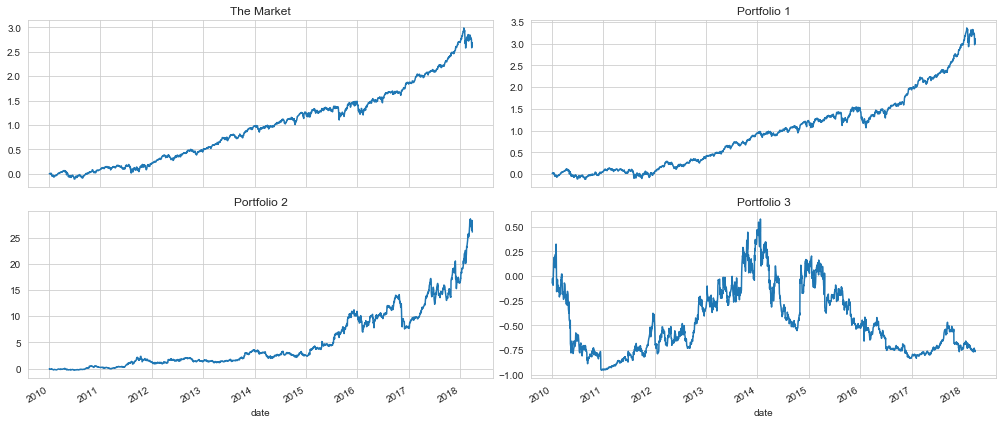

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,6), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0]);
for i in range(3):
    returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1).plot(title=f'Portfolio {i+1}', ax=axes[i+1])
fig.tight_layout()
plt.savefig('../figures/pca_eigen_pf_performance', dpi=300);